# Treinamento dos Modelos
Farei o treinamento de alguns modelos para prever o fechamento do Brent Oil e algumas outras métricas. Ao final treinarei um "meta-modelo" que irá combinar as previsões dos modelos anteriores para tentar melhorar a previsão.

Os modelos que irei treinar serão:

1. Random Forest
2. XGBoost
3. SARIMA

Para cada tipo de modelo irei treina-los para prever o fechamento do Brent Oil do dia seguinte (olhando para 7 dias atrás)

Por fim, utilizando feature importance, irei selecionar as features mais importantes para estimar o fechamento do Brent Oil e treinarei um modelo que irá combinar essas previsões utilizando linear regression.

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

## Coleta dos Dados

In [67]:
yf_brent_oil = yf.download('BZ=F')
yf_brent_oil.to_csv('brent_oil.csv')

[*********************100%%**********************]  1 of 1 completed


In [68]:
df_raw = pd.read_csv('brent_oil.csv')
df_raw.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume
1376,2013-03-19,109.010002,109.279999,107.279999,107.449997,107.449997,3327
1156,2012-04-19,118.849998,119.150002,117.709999,118.000000,118.000000,1122
777,2010-09-30,81.559998,82.370003,81.220001,82.309998,82.309998,426
2107,2016-02-26,35.090000,36.990002,34.849998,35.099998,35.099998,16272
1165,2012-05-02,119.199997,119.199997,117.769997,118.199997,118.199997,2624


## Preparação dos Dados

In [69]:
def calculate_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

def calculate_MACD(series, short_period=12, long_period=26, signal_period=9):
    short_ema = series.ewm(span=short_period, adjust=False).mean()
    long_ema = series.ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    histogram = macd - signal
    return macd, signal, histogram

def calculate_EMA(series, span=20):
    return series.ewm(span=span, adjust=False).mean()

def calculate_ADX(df, window=14):
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    tr = pd.concat([tr1, tr2, tr3], axis=1, join='inner').max(axis=1)
    
    atr = tr.rolling(window).mean()
    plus_di = 100 * (plus_dm.ewm(alpha=1/window).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/window).mean() / atr))
    
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = dx.rolling(window=window).mean()
    return adx

def index_rolling_window(df, window, pred_window=1):
    window_star_end = []
    pred_window_start_end = []
    for i in range(len(df) - window - pred_window + 1):
        window_star_end.append((i, i + window))
        pred_window_start_end.append((i + window, i + window + pred_window))
    
    return window_star_end, pred_window_start_end

def create_df(df, window, pred_window=1):

    df = df.copy()
    df['RSI'] = calculate_RSI(df['Close'], period=window)
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = calculate_MACD(df['Close'], short_period=window//2, long_period=window, signal_period=window//2.5)
    df['EMA'] = calculate_EMA(df['Close'], span=window)
    df['ADX'] = calculate_ADX(df, window=window)

    list_index_star_end, list_pred_index_star_end = index_rolling_window(df, window, pred_window)
    df_list = []
    for index_star_end, pred_index_star_end in zip(list_index_star_end, list_pred_index_star_end):
        index_start = index_star_end[0]
        index_end = index_star_end[1]
        pred_index_start = pred_index_star_end[0]
        pred_index_end = pred_index_star_end[1]

        features = df.iloc[index_start:index_end]
        pred = df.iloc[pred_index_start:pred_index_end]['Close']

        row = {
            'date': pd.to_datetime(df.iloc[pred_index_start]['Date']),
            'rolling_mean': features['Close'].mean(),
            'rolling_std': features['Close'].std(),
            'rolling_min': features['Close'].min(),
            'rolling_max': features['Close'].max(),
            'RSI': features['RSI'].mean(),
            'MACD': features['MACD'].mean(),
            'MACD_signal': features['MACD_signal'].mean(),
            'MACD_hist': features['MACD_hist'].mean(),
            'EMA': features['EMA'].mean(),
            'ADX': features['ADX'].mean(),
        }

        for lag in range(1, 4):
            row[f'lag_{lag}'] = features['Close'].iloc[-lag]

        row['y'] = pred.mean()

        df_list.append(row)
    return pd.DataFrame(df_list).dropna()

def plot_score_model(model, X_train, y_train, X_valid, y_valid, df_train, df_valid, title):

    yhat_train = model.predict(X_train)
    yhat_valid = model.predict(X_valid)

    print(f"""
        TRAIN:
        RMSE: {root_mean_squared_error(y_train, yhat_train)}
        MSE: {mean_squared_error(y_train, yhat_train)}
        MAE: {mean_absolute_error(y_train, yhat_train)}
        MAPE: {mean_absolute_percentage_error(y_train, yhat_train)}
        R2: {r2_score(y_train, yhat_train)}
        ====================
        VALID:
        RMSE: {root_mean_squared_error(y_valid, yhat_valid)}
        MSE: {mean_squared_error(y_valid, yhat_valid)}
        MAE: {mean_absolute_error(y_valid, yhat_valid)}
        MAPE: {mean_absolute_percentage_error(y_valid, yhat_valid)}
        R2: {r2_score(y_valid, yhat_valid)}
    """)

    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    ax[0].plot(df_train['date'], y_train, label='True')
    ax[0].plot(df_train['date'], yhat_train, label='Predicted')
    ax[0].set_title(f'Train - {title}')
    ax[0].legend()

    ax[1].plot(df_valid['date'], y_valid, label='True')
    ax[1].plot(df_valid['date'], yhat_valid, label='Predicted')
    ax[1].set_title(f'Valid - {title}')
    ax[1].legend()


In [70]:
pct_train = 0.75
pct_train_meta = 0.2

len_raw = len(df_raw)
df_train = df_raw.iloc[:int(len_raw * pct_train)].copy()
df_train_meta = df_raw.iloc[int(len_raw * pct_train):int(len_raw * (pct_train + pct_train_meta))].copy()
df_test = df_raw.iloc[int(len_raw * (pct_train + pct_train_meta)):].copy()

In [71]:
print(f"Raw shape: {df_raw.shape}")
print(f"Train shape: {df_train.shape}")
print(f"Train Meta shape: {df_train_meta.shape}")
print(f"Test shape: {df_test.shape}")

print(f"Train start: {df_train.iloc[0]['Date']} - Train end: {df_train.iloc[-1]['Date']}")
print(f"Train Meta start: {df_train_meta.iloc[0]['Date']} - Train Meta end: {df_train_meta.iloc[-1]['Date']}")
print(f"Test start: {df_test.iloc[0]['Date']} - Test end: {df_test.iloc[-1]['Date']}")

Raw shape: (4173, 7)
Train shape: (3129, 7)
Train Meta shape: (835, 7)
Test shape: (209, 7)
Train start: 2007-07-30 - Train end: 2020-03-24
Train Meta start: 2020-03-25 - Train Meta end: 2023-07-24
Test start: 2023-07-25 - Test end: 2024-05-20


Separando dataframe Treino e Validação

In [72]:
df_train_models = create_df(df_train, 7).dropna()
X_train_models = df_train_models.drop(['date', 'y'], axis=1)
y_train_models = df_train_models['y']

train_scaler = StandardScaler().fit(X_train_models)
X_train_models_scaled = train_scaler.transform(X_train_models)

df_train_meta = create_df(df_train_meta, 7).dropna()
X_train_meta = df_train_meta.drop(['date', 'y'], axis=1)
y_train_meta = df_train_meta['y']

df_test_models = create_df(df_test, 7).dropna()
X_test = df_test_models.drop(['date', 'y'], axis=1)
y_test = df_test_models['y']


## KNN Regressor

In [73]:
from sklearn.neighbors import KNeighborsRegressor

In [76]:
grid_search_knn = GridSearchCV(
    KNeighborsRegressor(), 
    {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }, 
    cv=TimeSeriesSplit(n_splits=5), 
    scoring='neg_mean_absolute_error', 
    verbose=2, 
    n_jobs=-1
)
grid_search_knn.fit(X_train_models_scaled, y_train_models)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s

[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, we

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error', verbose=2)

In [77]:
grid_search_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}

In [78]:
knn_model = KNeighborsRegressor(
    **{
        'metric': 'manhattan', 
        'n_neighbors': 11, 
        'weights': 'distance'
    }
).fit(X_train_models_scaled, y_train_models)


        TRAIN:
        RMSE: 0.0
        MSE: 0.0
        MAE: 0.0
        MAPE: 0.0
        R2: 1.0
        VALID:
        RMSE: 2.39396424633515
        MSE: 5.731064812731024
        MAE: 1.9612876882176986
        MAPE: 0.023273066671837244
        R2: 0.7683064164784996
    


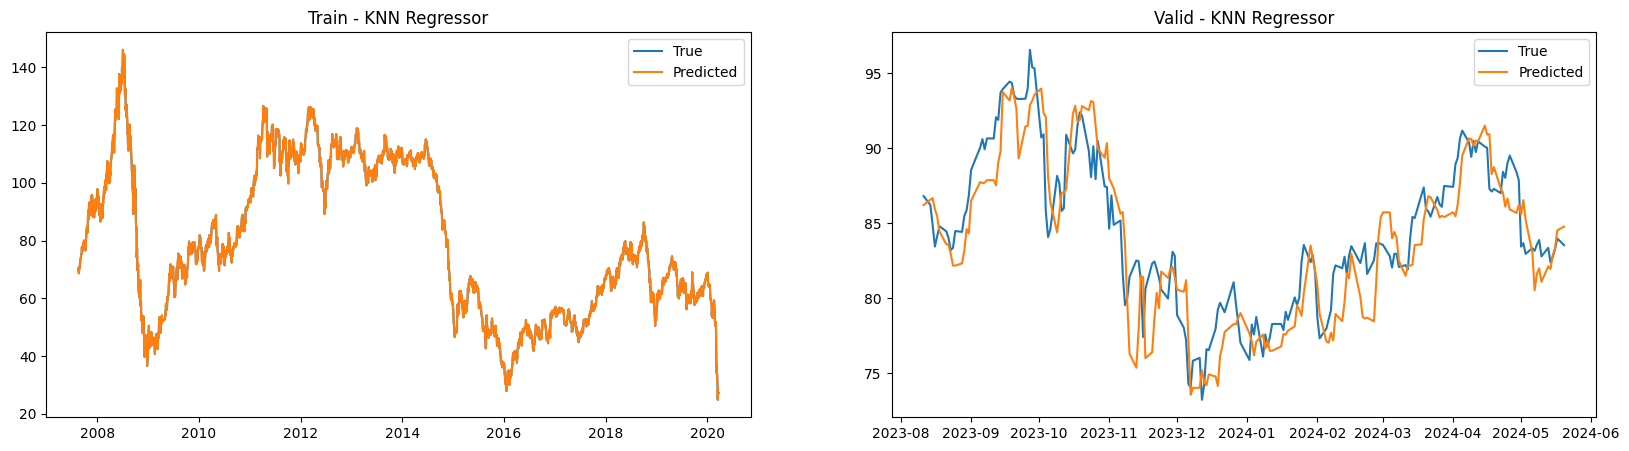

In [79]:
plot_score_model(
    knn_model, 
    X_train_models_scaled, 
    y_train_models, 
    train_scaler.transform(X_test), 
    y_test, 
    df_train_models, 
    df_test_models,
    "KNN Regressor"
)

## SVM

In [80]:
from sklearn.svm import LinearSVR

In [81]:
grid_search_svm = GridSearchCV(
    LinearSVR(dual='auto'), 
    {
        'C': [0.1, 0.5, 1, 5, 10],
        'epsilon': [0.1, 0.5, 1, 5, 10]
    }, 
    cv=TimeSeriesSplit(n_splits=5), 
    scoring='neg_mean_absolute_error', 
    verbose=2, 
    n_jobs=-1
)
grid_search_svm.fit(X_train_models_scaled, y_train_models)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .................................C=0.1, epsilon=0.1; total time=   0.0s
[CV] END .................................C=0.1, epsilon=0.1; total time=   0.0s
[CV] END .................................C=0.1, epsilon=0.1; total time=   0.0s
[CV] END .................................C=0.1, epsilon=0.1; total time=   0.0s
[CV] END .................................C=0.1, epsilon=0.5; total time=   0.0s
[CV] END .................................C=0.1, epsilon=0.1; total time=   0.0s
[CV] END .................................C=0.1, epsilon=0.5; total time=   0.0s
[CV] END .................................C=0.1, epsilon=0.5; total time=   0.0s
[CV] END .................................C=0.1, epsilon=0.5; total time=   0.0s
[CV] END ...................................C=0.1, epsilon=1; total time=   0.0s
[CV] END .................................C=0.1, epsilon=0.5; total time=   0.0s
[CV] END ...................................C=0

/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceW

[CV] END ..................................C=10, epsilon=0.1; total time=   0.0s
[CV] END ..................................C=10, epsilon=0.5; total time=   0.1s
[CV] END ....................................C=10, epsilon=1; total time=   0.0s
[CV] END ..................................C=10, epsilon=0.5; total time=   0.0s
[CV] END ....................................C=10, epsilon=1; total time=   0.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearSVR(dual='auto'), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 5, 10],
                         'epsilon': [0.1, 0.5, 1, 5, 10]},
             scoring='neg_mean_absolute_error', verbose=2)

In [82]:
grid_search_svm.best_params_

{'C': 10, 'epsilon': 0.5}

In [83]:
svm_model = LinearSVR(
    random_state=42,
    dual='auto',
    max_iter=10000,
    **{
        'C': 10,
        'epsilon': 0.5
    }
).fit(X_train_models_scaled, y_train_models)


        TRAIN:
        RMSE: 1.5821254682116284
        MSE: 2.5031209971638644
        MAE: 1.1153869160795256
        MAPE: 0.015343223354548963
        R2: 0.9962377971295024
        VALID:
        RMSE: 1.4778860740879538
        MSE: 2.184147247983105
        MAE: 1.0919073304801135
        MAPE: 0.013053939115286342
        R2: 0.9117000209630015
    


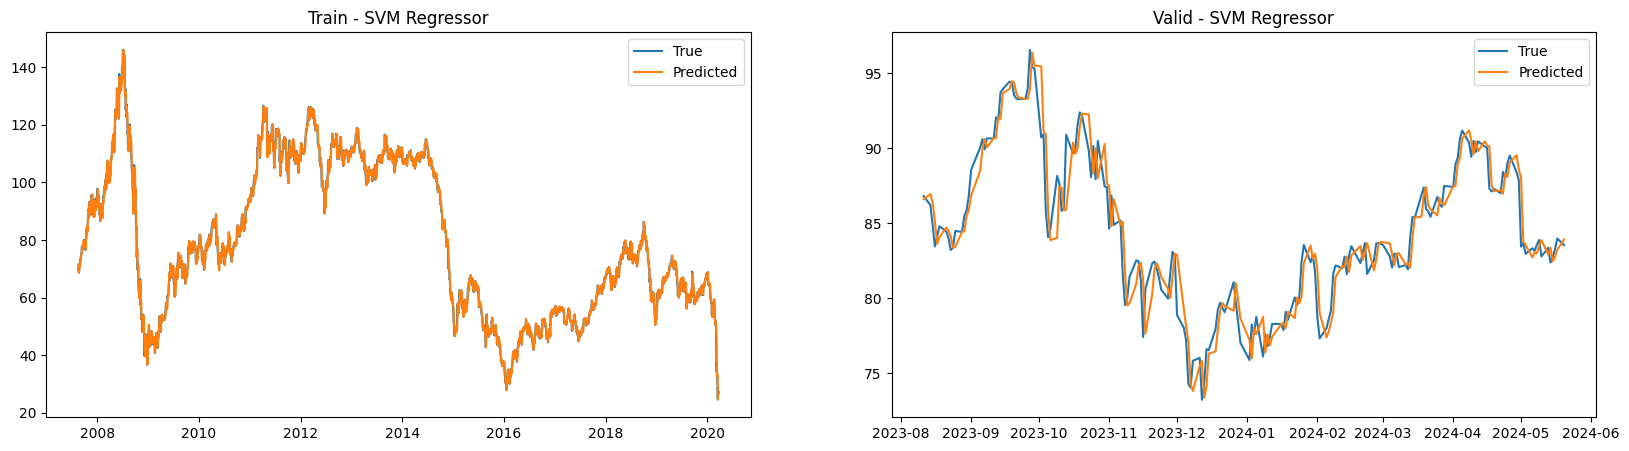

In [84]:
plot_score_model(
    svm_model, 
    X_train_models_scaled, 
    y_train_models, 
    train_scaler.transform(X_test), 
    y_test, 
    df_train_models, 
    df_test_models,
    "SVM Regressor"
)

## XGBoost

In [85]:
import xgboost as xgb

In [86]:
grid_search_xgb = GridSearchCV(
    xgb.XGBRegressor(), 
    {
        'n_estimators': [50, 100, 200, 600],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }, 
    cv=TimeSeriesSplit(n_splits=5), 
    scoring='neg_mean_absolute_error', 
    verbose=2, 
    n_jobs=-1
)
grid_search_xgb.fit(X_train_models, y_train_models)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsampl

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200, 600],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=2)

In [87]:
grid_search_xgb.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 600,
 'subsample': 0.8}

In [88]:
xgb_model = xgb.XGBRegressor(
    random_state=42,
    **{
        'colsample_bytree': 1.0,
        'learning_rate': 0.01,
        'max_depth': 3,
        'n_estimators': 600,
        'subsample': 0.8
    }
).fit(X_train_models, y_train_models)


        TRAIN:
        RMSE: 1.471703538842463
        MSE: 2.1659113062414295
        MAE: 1.0669695544457098
        MAPE: 0.01478832196251364
        R2: 0.9967446249131315
        VALID:
        RMSE: 1.5768788017285
        MSE: 2.48654675534071
        MAE: 1.193408031852878
        MAPE: 0.01424092680100903
        R2: 0.8994747141824572
    


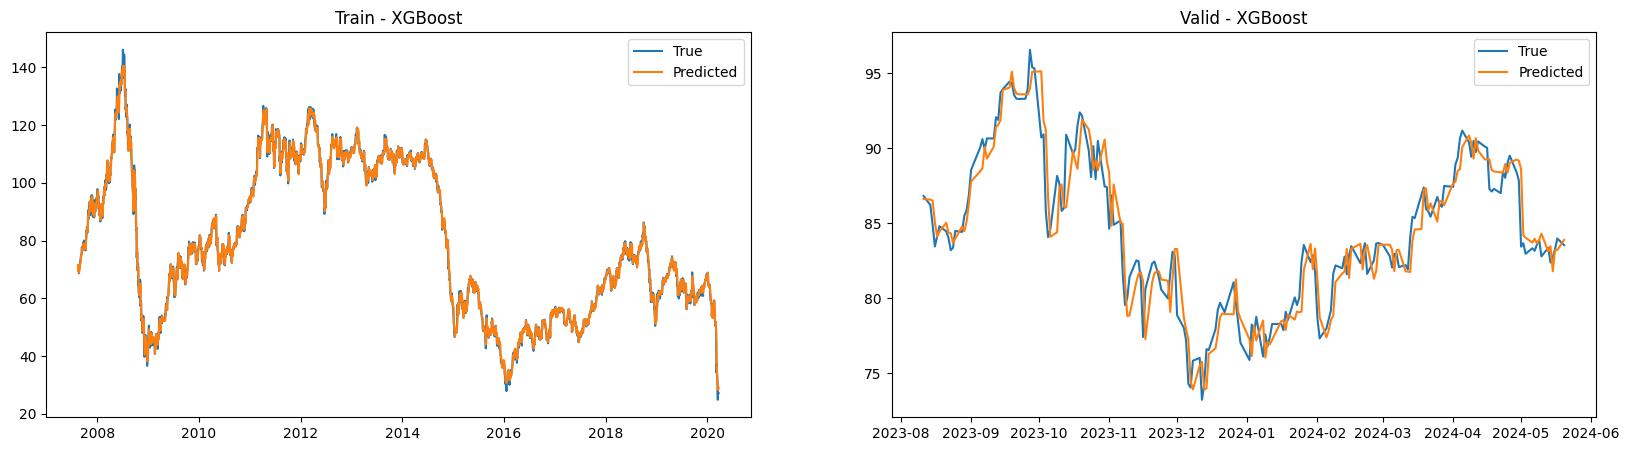

In [89]:
plot_score_model(
    xgb_model, 
    X_train_models, 
    y_train_models, 
    X_test, 
    y_test, 
    df_train_models, 
    df_test_models,
    "XGBoost"
)

## Bayesian Ridge

In [90]:
from sklearn.linear_model import BayesianRidge

In [91]:
grid_search_br = GridSearchCV(
    BayesianRidge(), 
    {
        'max_iter': [100, 300, 600, 1000],
        'alpha_1': [1e-6, 1e-5, 1e-4],
        'alpha_2': [1e-6, 1e-5, 1e-4],
        'lambda_1': [1e-6, 1e-5, 1e-4],
        'lambda_2': [1e-6, 1e-5, 1e-4],
    }, 
    cv=TimeSeriesSplit(n_splits=5), 
    scoring='neg_mean_absolute_error', 
    verbose=2, 
    n_jobs=-1
)
grid_search_br.fit(X_train_models_scaled, y_train_models)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, max_iter=100; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, max_iter=100; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, max_iter=100; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, max_iter=100; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, max_iter=100; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, max_iter=300; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, max_iter=300; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, max_iter=300; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, max_iter=300; total time=   0.0s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=BayesianRidge(), n_jobs=-1,
             param_grid={'alpha_1': [1e-06, 1e-05, 0.0001],
                         'alpha_2': [1e-06, 1e-05, 0.0001],
                         'lambda_1': [1e-06, 1e-05, 0.0001],
                         'lambda_2': [1e-06, 1e-05, 0.0001],
                         'max_iter': [100, 300, 600, 1000]},
             scoring='neg_mean_absolute_error', verbose=2)

In [92]:
grid_search_br.best_params_

{'alpha_1': 1e-06,
 'alpha_2': 0.0001,
 'lambda_1': 0.0001,
 'lambda_2': 1e-06,
 'max_iter': 100}

In [93]:
br_model = BayesianRidge(
    **{
        'alpha_1': 1e-06,
        'alpha_2': 0.0001,
        'lambda_1': 0.0001,
        'lambda_2': 1e-06,
        'max_iter': 100
    }
).fit(X_train_models_scaled, y_train_models)


        TRAIN:
        RMSE: 1.5793345009449338
        MSE: 2.494297465874983
        MAE: 1.117265380034646
        MAPE: 0.015369338556354292
        R2: 0.9962510589393713
        VALID:
        RMSE: 1.4790387310310757
        MSE: 2.187555567890015
        MAE: 1.0971295543331123
        MAPE: 0.013113018026390732
        R2: 0.911562230538565
    


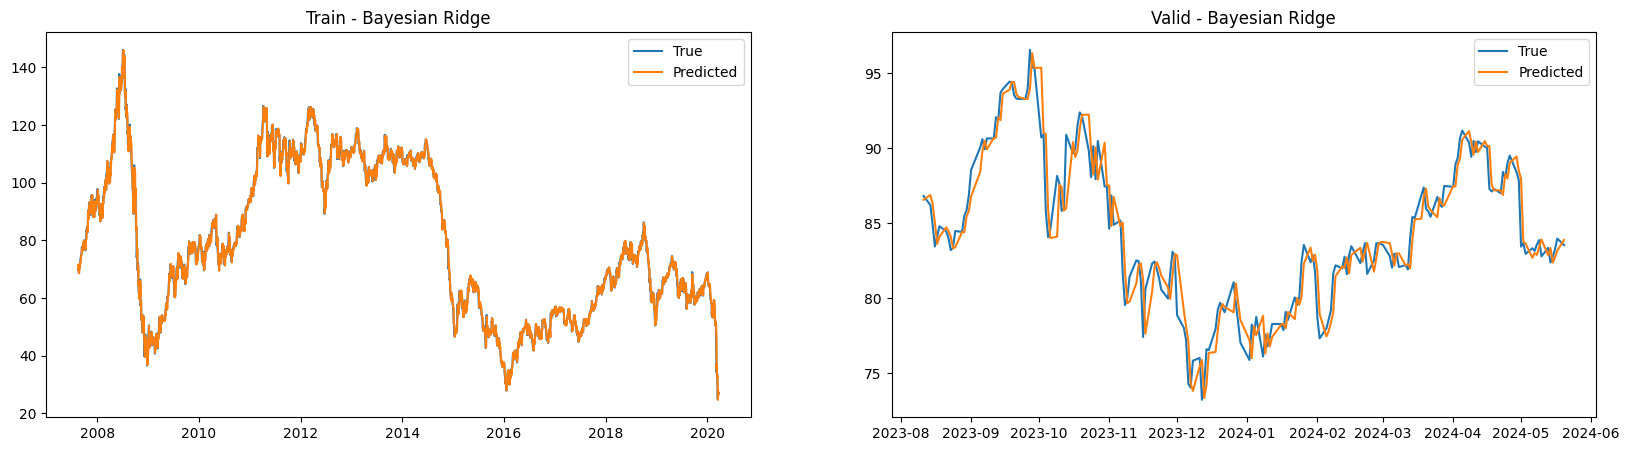

In [94]:
plot_score_model(
    br_model, 
    X_train_models_scaled, 
    y_train_models,
    train_scaler.transform(X_test), 
    y_test, 
    df_train_models, 
    df_test_models,
    "Bayesian Ridge"
)

## MLP

In [95]:
from sklearn.neural_network import MLPRegressor

In [96]:
grid_search_mlp = GridSearchCV(
    MLPRegressor(), 
    {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (50, 50, 50), (100, 100, 100), (50, 50, 50, 50), (100, 100, 100, 100)],
        'activation': ['identity', 'tanh', 'relu'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
    }, 
    cv=TimeSeriesSplit(n_splits=5), 
    scoring='neg_mean_absolute_error', 
    verbose=2, 
    n_jobs=-1
)
grid_search_mlp.fit(X_train_models_scaled, y_train_models)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.1s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.1s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.1s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.1s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.1s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.4s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.4s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.5s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.4s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.1s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.5s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.4s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.6s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.5s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.5s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.7s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.6s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.5s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.6s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   0.7s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   0.4s
[CV] END activation=identity, alpha=0.0001, hidden_layer_siz

/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.8s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   0.6s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.1s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.7s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.0s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   0.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.4s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.6s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.0s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.9s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.9s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.1s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.6s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.0s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   0.4s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   0.5s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.8s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   0.4s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   0.5s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.9s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.8s
[CV] END activation=i

/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.6s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   1.4s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.6s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.5s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.9s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   0.7s
[CV] END

/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.9s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.9s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.9s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.9s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.7s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.6s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.9s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.0s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.7s
[CV] 

/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   0.9s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   0.8s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   1.4s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   0.5s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   2.0s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   1.8s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant; total t

/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.2s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.2s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.4s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   2.0s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   1.9s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.1s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   1.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.2s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.1s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   1.5s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.4s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.1s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   1.9s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(10

/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.5s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.4s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.2s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.5s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.2s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.5s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.4s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.2s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.5s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.6s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.7s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.5s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.7s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   0.4s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   0.4s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.6s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.7s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.4s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   0.7s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.0s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.0s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   0.9s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.0s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.2s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.2s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.9s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.8s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.6s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.5s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.1s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.7s
[CV] END activation=identity, alpha=0.001, hidden_

/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.4s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.8s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.7s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.8s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   0.7s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.1s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   0.5s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   0.5s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   0.9s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   1.2s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.0s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   0.6s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   1.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   1.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   0.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.6s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.5s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.4s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.8s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.5s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.8s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.8s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.7s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.6s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.0s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   2.0s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.8s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   0.6s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.8s
[CV] EN

/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   1.8s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.2s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.1s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   1.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.2s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   2.1s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.2s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.1s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=  

/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   1.8s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.4s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   1.7s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.2s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.1s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.5s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.4s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.2s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.4s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.2s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.5s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.2s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.5s
[CV] END activation=identity, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   2.4s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.5s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), lear

/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.6s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.7s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.6s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.4s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   0.4s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.9s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   0.7s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.4s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.2s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.1s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.8s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.4s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.1s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.5s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.2s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.8s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.1s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.0s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.7s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.7s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes

/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.6s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.6s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.7s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   0.7s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   0.7s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   1.6s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   0.7s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.4s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.6s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   2.0s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.8s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.4s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   0.9s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.1s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.1s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.6s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.0s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.6s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.6s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.9s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.4s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.1s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   0.5s
[CV] END activati

/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   2.1s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   0.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.3s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   2.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   2.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.5s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   2.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.8s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   2.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   1.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   1.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   1.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   1.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   1.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   2.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   2.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   2.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   2.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   2.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   2.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   0.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   0.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   1.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   0.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   2.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   2.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   3.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   4.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   3.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   2.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   4.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   3.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   2.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   2.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   4.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   2.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   2.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   1.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   2.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   2.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   2.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   2.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   1.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   3.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   3.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   5.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   2.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   6.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   5.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   3.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   6.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   4.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   1.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   5.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   1.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   1.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   1.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   2.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   2.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   2.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   2.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   2.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   2.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   2.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   0.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   0.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   2.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   1.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   2.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   0.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   3.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   2.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   4.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   3.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   2.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   4.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   3.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   2.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   2.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   4.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   2.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   2.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   1.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   2.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   2.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   2.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   2.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   3.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   3.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   5.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   2.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   6.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   5.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   3.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   6.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   4.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   1.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   1.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   1.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   1.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   6.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   1.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   2.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   2.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   2.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   2.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   2.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   2.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   2.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   0.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   0.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   1.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   2.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   2.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   3.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   2.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   4.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   3.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   3.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   4.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   4.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   2.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   3.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   5.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   2.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   2.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   3.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   2.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   3.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   3.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   3.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   2.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   1.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   4.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   4.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   6.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   2.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   7.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   5.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   4.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   1.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   7.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   1.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   5.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   1.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   1.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   1.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   1.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   7.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   2.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   2.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   2.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   2.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   2.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   2.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   0.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   1.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   2.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   2.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   2.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   3.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   2.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   3.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   2.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   3.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   2.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   1.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   2.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   1.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   2.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   1.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   3.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   3.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   1.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   2.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   3.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   2.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   3.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   3.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   2.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   4.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   4.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   1.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   1.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   0.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   1.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   2.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   2.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   2.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   2.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   2.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   2.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   1.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   2.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   2.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   2.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   3.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   3.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   2.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   3.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   4.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   3.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   3.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   2.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   4.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   1.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   1.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   1.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   1.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   2.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   3.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   3.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   3.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   4.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   4.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   2.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=invscaling; total time=   0.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   2.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   5.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   3.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   3.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant; total time=   0.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling; total time=   0.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   0.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant; total time=   1.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling; total time=   1.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   0.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=   1.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   0.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   1.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   2.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant; total time=   2.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   2.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   1.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=invscaling; total time=   2.5s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   2.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   0.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive; total time=   2.7s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   1.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   1.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   1.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling; total time=   2.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   1.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   2.1s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   2.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   2.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   1.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   3.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   2.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   3.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   3.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   1.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   0.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   2.9s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=constant; total time=   5.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   2.6s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=invscaling; total time=   4.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   1.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   3.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.0s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive; total time=   4.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=constant; total time=   2.3s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   1.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=invscaling; total time=   2.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   1.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   1.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50), learning_rate=adaptive; total time=   2.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   1.2s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   2.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   3.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   2.4s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   1.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   3.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   3.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   3.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   2.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   2.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=invscaling; total time=   4.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant; total time=   5.8s


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   3.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive; total time=   3.5s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['identity', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 100), (50, 50, 50),
                                                (100, 100, 100),
                                                (50, 50, 50, 50),
                                                (100, 100, 100, 100)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='neg_mean_absolute_error', verbose=2)

In [97]:
grid_search_mlp.best_params_

{'activation': 'identity',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100, 100),
 'learning_rate': 'invscaling'}

In [98]:
mlp_model = MLPRegressor(
    **{
        'activation': 'identity',
        'alpha': 0.001,
        'hidden_layer_sizes': (50, 50, 50, 50),
        'learning_rate': 'invscaling'
    }
).fit(X_train_models_scaled, y_train_models)


        TRAIN:
        RMSE: 1.602345218538965
        MSE: 2.567510199374684
        MAE: 1.1439898201079703
        MAPE: 0.015686208581213685
        R2: 0.9961410198495942
        VALID:
        RMSE: 1.4997093963606833
        MSE: 2.2491282735325253
        MAE: 1.1250617553738398
        MAPE: 0.013415880543564662
        R2: 0.9090729896586264
    


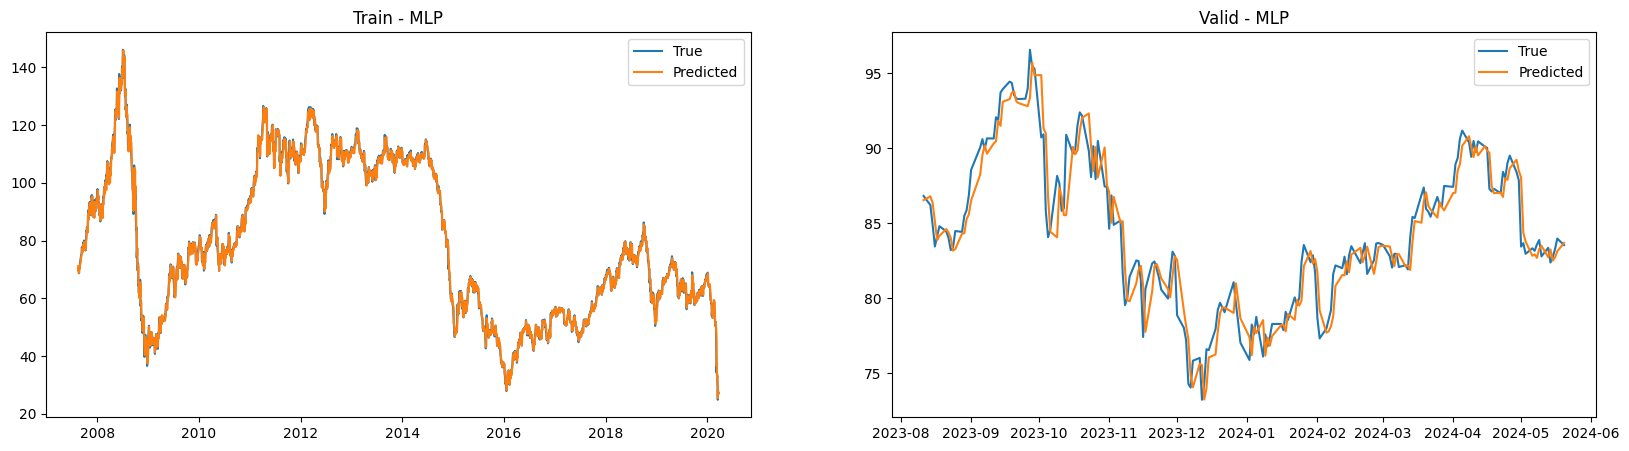

In [99]:
plot_score_model(
    mlp_model, 
    X_train_models_scaled, 
    y_train_models,
    train_scaler.transform(X_test), 
    y_test, 
    df_train_models, 
    df_test_models,
    "MLP"
)

# Meta-Modelo

Adicionando as previsões dos modelos anteriores

In [100]:
predict_knn = knn_model.predict(train_scaler.transform(X_train_meta))
predict_svm = svm_model.predict(train_scaler.transform(X_train_meta))
predict_xgb = xgb_model.predict(X_train_meta)
preict_br = br_model.predict(train_scaler.transform(X_train_meta))
predict_mlp = mlp_model.predict(train_scaler.transform(X_train_meta))

predict_knn_test = knn_model.predict(train_scaler.transform(X_test))
predict_svm_test = svm_model.predict(train_scaler.transform(X_test))
predict_xgb_test = xgb_model.predict(X_test)
preict_br_test = br_model.predict(train_scaler.transform(X_test))
predict_mlp_test = mlp_model.predict(train_scaler.transform(X_test))

In [101]:
X_train_meta['knn'] = predict_knn
X_train_meta['svm'] = predict_svm
X_train_meta['xgb'] = predict_xgb
X_train_meta['br'] = preict_br
X_train_meta['mlp'] = predict_mlp

X_test['knn'] = predict_knn_test
X_test['svm'] = predict_svm_test
X_test['xgb'] = predict_xgb_test
X_test['br'] = preict_br_test
X_test['mlp'] = predict_mlp_test

In [102]:
from sklearn.linear_model import Lasso

In [103]:
grid_search_meta = GridSearchCV(
    Lasso(), 
    {
        'alpha': [0.1, 0.5, 1, 5, 10]
    }, 
    cv=TimeSeriesSplit(n_splits=5), 
    scoring='neg_mean_squared_error', 
    verbose=2, 
    n_jobs=-1
)
grid_search_meta.fit(X_train_meta, y_train_meta)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ........................................

/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e+00, tolerance: 5.930e-01
  model = cd_fast.enet_coordinate_descent(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.410e+02, tolerance: 3.288e+01
  model = cd_fast.enet_coordinate_descent(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1, 5, 10]},
             scoring='neg_mean_squared_error', verbose=2)

In [104]:
grid_search_meta.best_params_

{'alpha': 0.5}

In [105]:
meta_model = Lasso(
    alpha = 0.5
).fit(X_train_meta, y_train_meta)


        TRAIN:
        RMSE: 2.0650123152094726
        MSE: 4.2642758619667855
        MAE: 1.3886670227543707
        MAPE: 0.01896912854018522
        R2: 0.9916939916675914
        VALID:
        RMSE: 1.4534636550468842
        MSE: 2.112556596542248
        MAE: 1.0623833870788995
        MAPE: 0.012683727067378052
        R2: 0.914594264026197
    


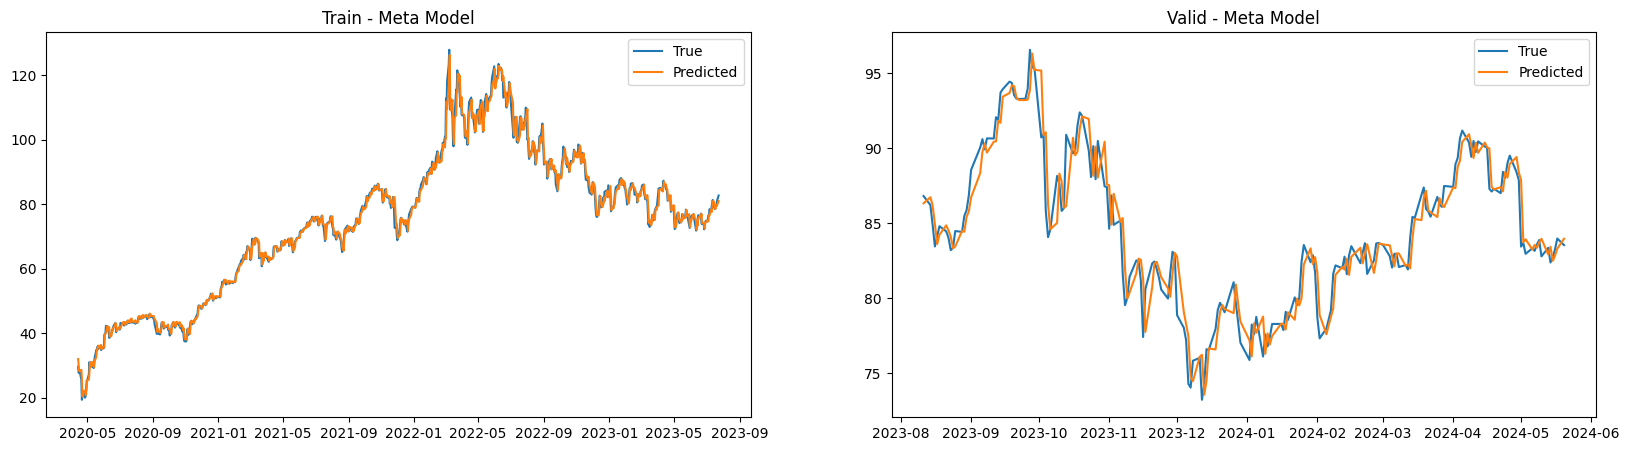

In [106]:
plot_score_model(
    meta_model, 
    X_train_meta, 
    y_train_meta, 
    X_test, 
    y_test, 
    df_train_meta, 
    df_test_models,
    "Meta Model"
)


In [ ]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(meta_model, prefit=True)
X_train_selected = selector.transform(X_train_meta)
X_test_selected = selector.transform(X_test)

print(f"Número de features original: {X_train_meta.shape[1]}")
print(f"Número de features após seleção: {X_train_selected.shape[1]}")

Número de features original: 17
Número de features após seleção: 4


/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/zfab/repos/postech/tech-challenge/f4-brent-oil/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
indices = selector.get_support(indices=True)
X_train_meta.columns[indices]

Index(['RSI', 'EMA', 'lag_1', 'xgb'], dtype='object')

# Baseline
Modelo Baseline onde a previsão é sempre o valor do dia anterior

In [ ]:
df_test_baseline = df_test[['Date', 'Close']].copy()

In [ ]:
df_test_baseline['yhat'] = df_test['Close'].shift(1)
df_test_baseline.dropna(inplace=True)


    Test:
    MSE: 2.085814924366648
    MAE: 1.0784616470336916
    R2: 0.9110036678624333
    MAPE: 0.012869016930326601



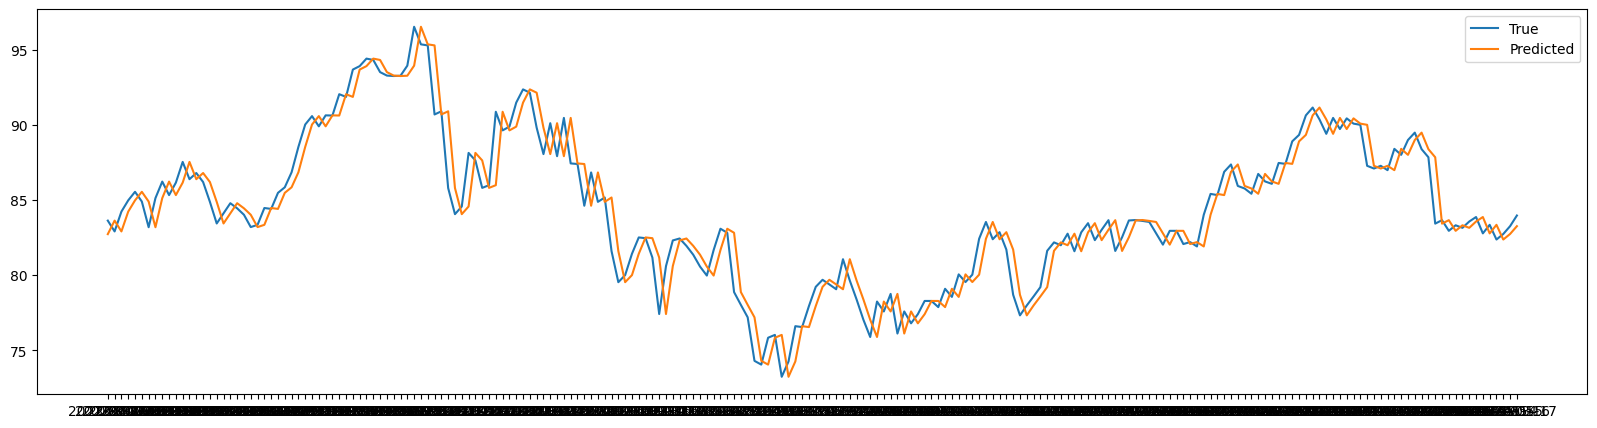

In [ ]:
y_test_pred = df_test_baseline['yhat']
y_test = df_test_baseline['Close']

print(f"""
    Test:
    MSE: {mean_squared_error(y_test, y_test_pred)}
    MAE: {mean_absolute_error(y_test, y_test_pred)}
    R2: {r2_score(y_test, y_test_pred)}
    MAPE: {mean_absolute_percentage_error(y_test, y_test_pred)}
""")

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_test_baseline['Date'], df_test_baseline['Close'], label='True')
ax.plot(df_test_baseline['Date'], y_test_pred, label='Predicted')
ax.legend()

# Save Model

In [107]:
import joblib

dict_model = {
    'col_models': X_train_models.columns,
    'col_meta': X_train_meta.columns,
    'scaler': train_scaler,
    'meta_model': meta_model,
    'models': {
        'knn': knn_model,
        'svm': svm_model,
        'xgb': xgb_model,
        'br': br_model,
        'mlp': mlp_model
    }
}

joblib.dump(dict_model, filename="models-f4.joblib")

['models-f4.joblib']